In [143]:
# the fast.ai library, used to easily build neural networks and train them
from fastai import *
from fastai.vision.all import *
from fastai.basics import *
from fastai.data import *

import pandas as pd
from ipywidgets import interact, IntSlider

In [98]:
# Get the MNIST data 
mnist_path = untar_data(URLs.MNIST_TINY)
mnist_label = pd.read_csv(f'{mnist_path}/labels.csv')
mnist_label['filename'] =  mnist_label['name'].apply(lambda x: os.path.basename(x))
mnist_label.head()

,name,label,filename
0,train/3/7463.png,3,7463.png
1,train/3/9829.png,3,9829.png
2,train/3/7881.png,3,7881.png
3,train/3/8065.png,3,8065.png
4,train/3/7046.png,3,7046.png


In [120]:
# Load the dataset
def get_image_label(p):
    f = os.path.basename(p)
    return mnist_label[mnist_label['filename'] == f].label.values[0]


mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                  get_y = get_image_label,
                  item_tfms=[ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)])
dsets = mnist.datasets(mnist_path)

In [121]:
mnist.summary(source=mnist_path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_image_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/ajithj/.fastai/data/mnist_tiny/train/7/9243.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: get_image_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/ajithj/.fastai/data/mnist_tiny/train/7/9243.png
    applying get_image_label gives
      7
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_image_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_i

Training dataset size: 709
Validation dataset size: 699


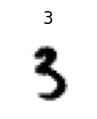

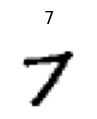

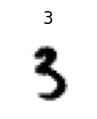

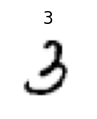

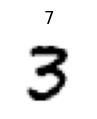

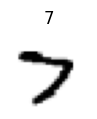

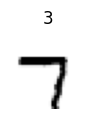

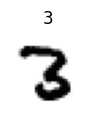

In [122]:
# pick randomly 4 images and plot them with label.
print(f'Training dataset size: {len(dsets.train)}')

for i in torch.randint(len(dsets.train),size=(4,)):
    show_at(dsets.train, i, cmap='Greys', figsize=(1,1));

# Validate the images in validation split as well
print(f'Validation dataset size: {len(dsets.valid)}')

for j in torch.randint(len(dsets.valid),size=(4,)):
    show_at(dsets.valid, j, cmap='Greys', figsize=(1,1));

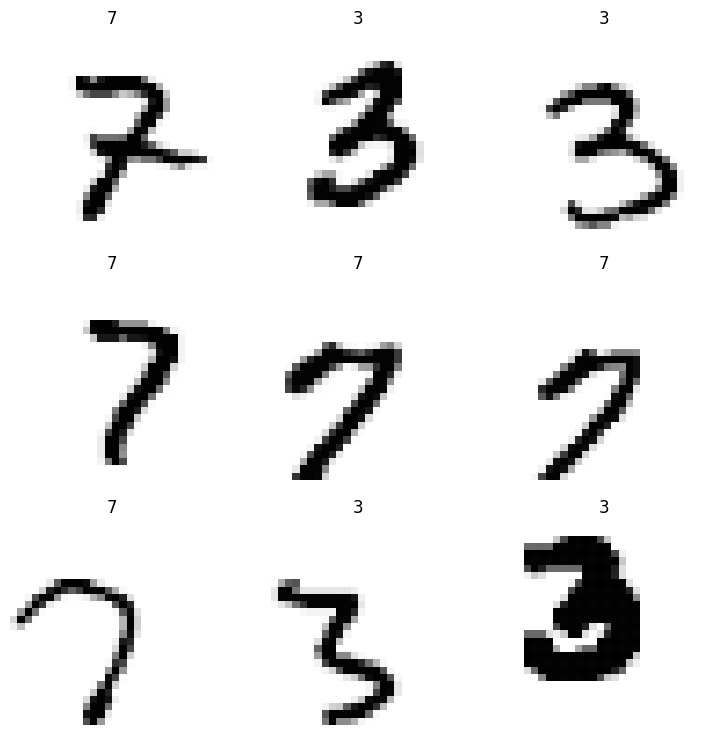

In [124]:
mnist_dls = mnist.dataloaders(mnist_path, bs=32)
mnist_dls.show_batch()

In [127]:
# Understand the pipeline for one iteration 
xb, yb = mnist_dls.one_batch()
xb.shape, yb.shape, mnist_dls.c

(torch.Size([32, 1, 28, 28]), torch.Size([32]), 2)

In [148]:
#So our input shape will be a [32 x 1 x 28 x 28] and our output shape will be a [32] tensor that we need to condense into 2 classes
# 32 is our batch size
# 28 x 28 is the normalized, transformed tensor image
# Only two classes in the tiny dataset - 3 and 7
@interact(index=IntSlider(min=0, max=32, step=1, value=0))
def plot_digit(index):
    fig, ax = plt.subplots(figsize=(12, 12))
    img_array = xb[index][0]
    img = ax.imshow(img_array, cmap='gray') 
    for x in range(28):
        for y in range(28):
            value = img_array[y][x]
            color = 'black' if value > 0.5 else 'white'
            ax.annotate(text=f'{value:.2f}', xy=(x, y), ha='center', va='center', color=color)

    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=0, description='index', max=32), Output()), _dom_classes=('widget-intera…

In [154]:
# Understanding CNN
# https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
# Reference book: http://neuralnetworksanddeeplearning.com/chap1.html
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
def bn(nf): return nn.BatchNorm2d(nf)
def ReLU(): return nn.ReLU(inplace=False)

model = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,48),
    bn(48),
    ReLU(),
    conv(48, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

In [155]:
learn = Learner(mnist_dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.summary()

Sequential (Input shape: 32 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8 x 14 x 14    
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 7 x 7     
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 48 x 4 x 4     
Conv2d                                    6960       True      
BatchNorm2d                               96         True      
ReLU                                                           
_____________________________________

SuggestedLRs(valley=0.009120108559727669)

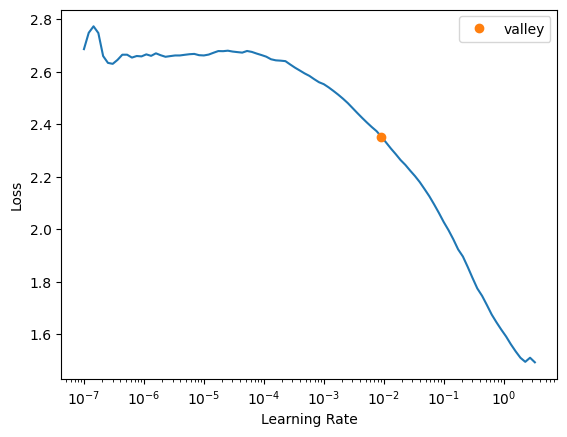

In [156]:
learn.lr_find()

In [158]:
# Start with learning rate of 0.1
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.216704,2.336861,0.493562,00:03
1,0.220030,1.305974,0.842632,00:03
2,0.174539,0.635679,0.898426,00:03


In [159]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)
model2D = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

learn = Learner(mnist_dls, model2D, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.summary()

Sequential (Input shape: 32 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8 x 14 x 14    
Conv2d                                    72         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 7 x 7     
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 4 x 4     
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
_____________________________________

In [160]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.476101,0.846440,0.875537,00:04
1,0.755454,0.568866,0.901288,00:03
2,0.470781,0.546709,0.902718,00:03


In [161]:
class ConvBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf)
        self.conv2 = ConvLayer(nf, nf)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))
    

In [163]:
block_model = nn.Sequential(
    conv2(1,8),
    ConvBlock(8),
    conv2(8,16),
    ConvBlock(16),
    conv2(16,32),
    ConvBlock(32),
    conv2(32,16),
    ConvBlock(16),
    conv2(16,10),
    Flatten()
)
block_model

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stri

In [164]:
def conv_layer_block(ni, nf): return nn.Sequential(conv2(ni, nf), ConvBlock(nf))

net = nn.Sequential(
    conv_layer_block(1,8),
    conv_layer_block(8,16),
    conv_layer_block(16,32),
    conv_layer_block(32,16),
    conv2(16,10),
    Flatten()
)
net

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvBlock(
      (conv1): ConvLayer(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): ConvLayer(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (1): Sequential(
    (0): ConvLayer(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1

SuggestedLRs(valley=0.007585775572806597)

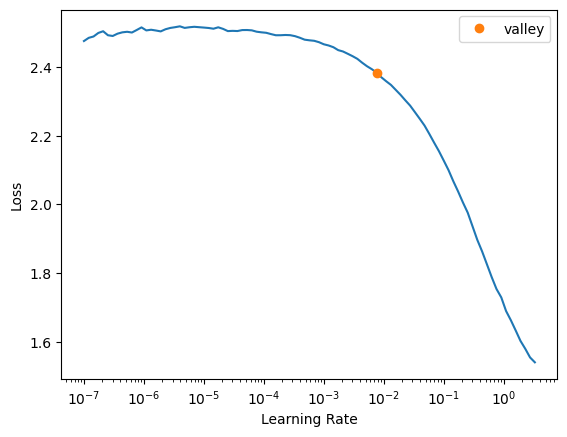

In [166]:
learn = Learner(mnist_dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

In [168]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.166755,0.653665,0.882690,00:03
1,0.149986,0.642037,0.889843,00:03
2,0.118440,0.618289,0.889843,00:03
3,0.105268,0.635054,0.901288,00:03
4,0.107255,0.627160,0.907010,00:03


In [175]:
dsets.valid[0]


(PILImageBW mode=L size=28x28, TensorCategory(0))

Predicted digit = 3, Confidence: ['3 : 99.12%', '7 : 0.10%']


Predicted digit = 3, Confidence: ['3 : 99.00%', '7 : 0.11%']


Predicted digit = 3, Confidence: ['3 : 98.34%', '7 : 0.18%']


Predicted digit = 7, Confidence: ['3 : 0.11%', '7 : 99.04%']


Predicted digit = 7, Confidence: ['3 : 0.09%', '7 : 99.19%']


Predicted digit = 7, Confidence: ['3 : 0.09%', '7 : 99.18%']


Predicted digit = 7, Confidence: ['3 : 5.67%', '7 : 91.23%']


Predicted digit = 3, Confidence: ['3 : 98.92%', '7 : 0.12%']


Predicted digit = 3, Confidence: ['3 : 99.14%', '7 : 0.10%']


Predicted digit = 7, Confidence: ['3 : 0.16%', '7 : 98.67%']


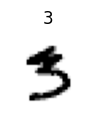

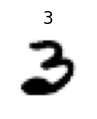

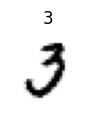

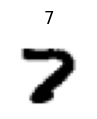

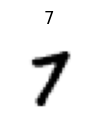

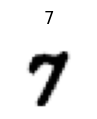

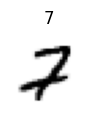

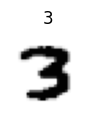

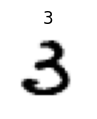

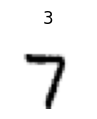

In [186]:

for j in torch.randint(len(dsets.valid),size=(10,)):
    show_at(dsets.valid, j, cmap='Greys', figsize=(1,1));
    img, size = dsets.valid[j]
    digit, idx, probs = learn.predict(img)
    probs_map = [ f'{k} : {100* v:.2f}%' for k,v in dict(zip(learn.dls.vocab, map(float, probs))).items() ]
    print(f'Predicted digit = {digit}, Confidence: {probs_map}')

In [185]:
learn.export('mnist-tiny.pkl')

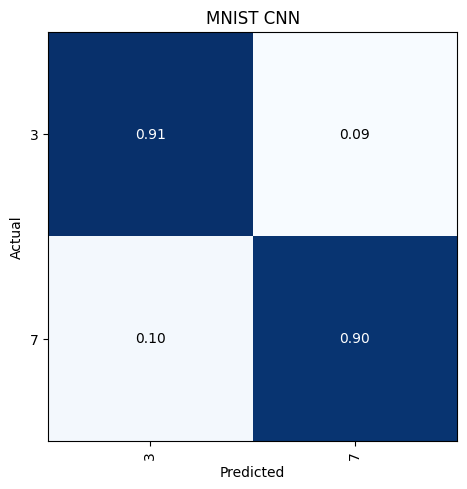

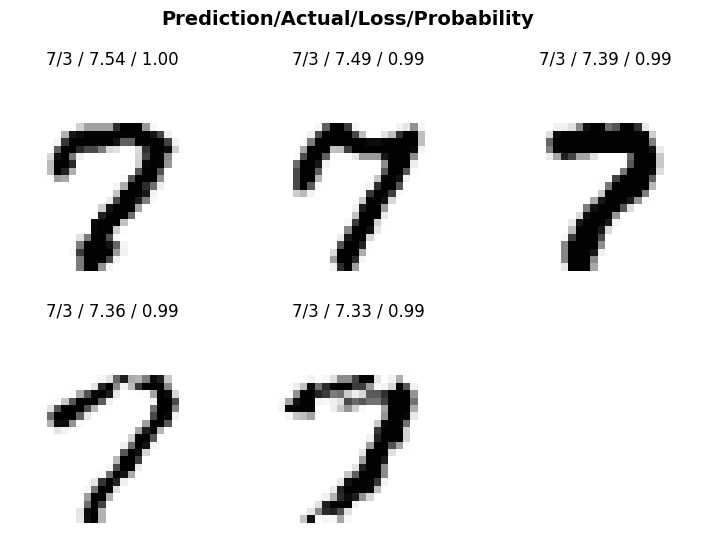

In [188]:
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix(title='MNIST CNN', normalize=True)
  interp.plot_top_losses(k=5)